In [5]:
import numpy as np
import matplotlib.pyplot as plt

totalExpected = 11.24
totalExpectedE = 1.99

toyExpCollection = []

for i in range(0,30000+1):

    expectedToy = np.random.normal(totalExpected, totalExpectedE)
    observedToyExp = np.random.poisson(expectedToy)
    
    toyExpCollection.append(observedToyExp)

    
binNumber = max(toyExpCollection) - min(toyExpCollection)

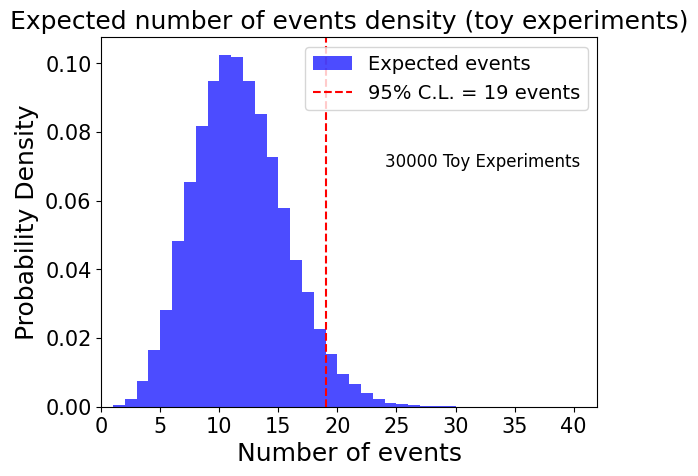

In [6]:
histogram = plt.hist(toyExpCollection, bins=binNumber, density=True, alpha=0.7, color='blue', label='Expected events')

# Add labels and a legend
plt.xlabel('Number of events',fontsize=18)
plt.ylabel('Probability Density',fontsize=18)
plt.title('Expected number of events density (toy experiments)',fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(0, 42)

plt.text(24,0.07,'30000 Toy Experiments', fontsize=12, color='black')

pdf = histogram[0]
CL95 = 0.95*np.sum(pdf)
limit = 0
for i in range(0,len(pdf)):
    if np.sum(pdf[0:i])>=CL95:
        limit = histogram[1][i]
        break

# Add a vertical line
vertical_line_x = limit  # x-coordinate where you want the vertical line
plt.axvline(x=vertical_line_x, color='red', linestyle='--', label='95% C.L. = '+str(int(limit))+ ' events')

plt.legend(fontsize = 14)

# Show the plot
plt.savefig('CL95.pdf',bbox_inches='tight')
plt.show()
